# Lesson 1: Recognizing Cats and Dogs

## 00:02:18 - Top-down vs bottom up

* Bottup-up: learn each building block then eventually put them together.
  * Traditional way stuff is taught.
  * Problems:
    * Hard to maintain motivation.
    * Hard to know the "big picture".
    * Hard to know which pieces you'll actually need.
* Top-down: learn  by doing; slowly peal back the layers of the building blocks.
  * Fast.ai: start using neural net to get results straight away.
  
## 00:02:40 - GPUs

* Training neural network requires a GPU.
  * Requires an Nvidia GPU because they are the only ones that support CUDA.
* Renting GPUs:
  * Crestle (00:04:12)
    * Easiest.
    * Instant.
    * Provides access to only Jupyter Notebooks, not servers.
  * Paperspace (00:06:20)
    * Doesn't run on top of Amazon.
    * Provides their own virtual machines.
* Instructions on how to setup Paperspace (00:06:30)
  * Choose region.
  * Choose OS (Ubuntu 16.04)
  * Choose GPU+ (only 0.40 an hour)
    * Choosing a 0.65 / hr machine may require you to contact Paperspace to say why you're using it. Just say "Fast.AI".
  * To configure machine for course, log into terminal and type: ``curl http://files.fast.ai/setup/paperspace | bash``
    * After running, need to restart Paperspace machine.
* Directory layout:
  * ``anaconda3``
  * ``fastai``
    * Course project directory.
* To start notebook:
  * cd into fastai directory and type ``juypter notebook``.
  * Open ``lesson1.ipynb``
  
##  00:13:00 - Jupyter instructions

* To run a cell: select the cell and hold down shift and press enter.
* Can also click the "Run" button.

In [4]:
# Put these at the top of every notebook to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [58]:
import numpy as np
import matplotlib.pyplot as plt

from fastai import fastai
from fastai.fastai import transforms
from fastai.fastai import conv_learner
from fastai.fastai import model
from fastai.fastai import dataset
from fastai.fastai import sgdr
from fastai.fastai import plots as faplots

In [6]:
PATH = "data/dogscats/"
sz = 244

## 00:14:20 - Python version note

* Course uses Python 3. Will get errors if using Python 2.
* Important to switch to Python 3 - most libraries switching to it.

## 00:15:05 - Extra steps if not using Fast.AI scripts

* Need to download the dogs and cats set to the data directory as follows:

In [11]:
!ls -l

total 16
drwxrwxr-x 7 lex lex 4096 Mar 26 22:19 fastai
-rw-rw-r-- 1 lex lex 4337 Mar 26 23:33 lesson1.ipynb
-rw-rw-r-- 1 lex lex  282 Mar 26 22:19 README.md


In [12]:
!mkdir data

In [13]:
!ls -l

total 20
drwxrwxr-x 2 lex lex 4096 Mar 26 23:33 data
drwxrwxr-x 7 lex lex 4096 Mar 26 22:19 fastai
-rw-rw-r-- 1 lex lex 4337 Mar 26 23:33 lesson1.ipynb
-rw-rw-r-- 1 lex lex  282 Mar 26 22:19 README.md


In [14]:
!cd data && wget http://files.fast.ai/data/dogscats.zip

--2018-03-26 23:33:41--  http://files.fast.ai/data/dogscats.zip
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857214334 (818M) [application/zip]
Saving to: ‘dogscats.zip’

dogscats.zip        100%[===================>] 817.50M  16.9MB/s    in 83s     

2018-03-26 23:35:04 (9.88 MB/s) - ‘dogscats.zip’ saved [857214334/857214334]



In [18]:
!cd data && unzip -q dogscats.zip

In [19]:
!ls -l data/dogscats/

total 288
drwxrwxr-x 2 lex lex   4096 Oct 15  2016 models
drwxrwxr-x 4 lex lex   4096 Oct  4  2016 sample
drwxr-xr-x 2 lex lex 278528 Sep 20  2013 test1
drwxr-xr-x 4 lex lex   4096 Oct  7  2016 train
drwxrwxr-x 4 lex lex   4096 Oct  7  2016 valid


## 00:15:40 - First look at cat pictures

* Can use {some_var} to use Python variables in bash syntax:

In [20]:
!ls {PATH}

models	sample	test1  train  valid


In [21]:
!ls {PATH}valid

cats  dogs


In [23]:
files = !ls {PATH}valid/cats | head
files

['cat.10016.jpg',
 'cat.1001.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

* Notes on training/validation sets:
    * If you are not familiar with train and validation set, checkout [Fast.AI: Practical Machine Learning course](http://forums.fast.ai/t/another-treat-early-access-to-intro-to-machine-learning-videos/6826?source_topic_id=9285&source_topic_id=9594) (00:16:18).
    * Fast.AI philosphy: learn things as you need them.

* Common way to setup folders for image classification is to assign each image to a "class" (ie `dogs` or `cats`) folder.
* Take a look at one image at random:

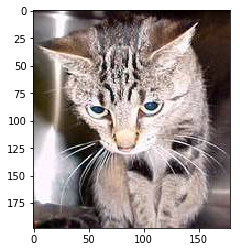

In [27]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img)

* Note that we're using [Python 3's new f-string syntax](https://cito.github.io/blog/f-strings/).

* Mainly interested in underlying data. Let's look at the shape:

In [28]:
img.shape

(198, 179, 3)

* Shape is a 3-dimensional array, also called a "rank 3 tensor".
* Here are the first 4 rows and columns:

In [29]:
img[:4, :4]

array([[[ 29,  20,  23],
        [ 31,  22,  25],
        [ 34,  25,  28],
        [ 37,  28,  31]],

       [[ 60,  51,  54],
        [ 58,  49,  52],
        [ 56,  47,  50],
        [ 55,  46,  49]],

       [[ 93,  84,  87],
        [ 89,  80,  83],
        [ 85,  76,  79],
        [ 81,  72,  75]],

       [[104,  95,  98],
        [103,  94,  97],
        [102,  93,  96],
        [102,  93,  96]]], dtype=uint8)

* Basic project idea: take those numbers from the image and use them to predict whether they represent a cat or a dog based on lots of pictures of cats and dogs (00:19:45).
* When the Kaggle competition for cats and dogs was first introduced in 2012, the state of the art was around 80% accuracy.

## 00:20:24 - Training our model

* Only 3 lines of code necessary to train a model:

In [31]:
from torchvision.models import resnet18, resnet34

arch = resnet34
data = dataset.ImageClassifierData.from_paths(PATH, tfms=transforms.tfms_from_model(arch, sz))
learn = conv_learner.ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

100%|██████████| 32/32 [00:14<00:00,  2.25it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      0.055908   0.023253   0.991699  
    1      0.041379   0.030945   0.990723                     
    2      0.044082   0.025078   0.992188                     



[0.025078129, 0.9921875]

* The first time the model is run it downloads the model then precomputes activations, so will be slower.
* You can see 3 lines of output, since we ran 3 epochs.
* The 3 bits of data return for each input is, in order, as follows (00:21:05):
  1. Value of the loss function on the training set, which is cross entropy loss (covered later).
  2. Loss function on the val set.
  3. Accuracy on the validation set.

##  00:22:30 - Fast AI Library

* Deep learning known for needing lots of compute and lots of data. Not necessarily true.
* Fast.AI library takes all of the best practise approachs they can find.
  * When papers come out, they implement it in fast.ai.
  * Automatically figures out the best way to handle things.
* Sits on top of PyTorch.
  * Tends to be more flexible than the popular Tensorflow.

## 00:24:12 - What does the model look like?

* Can take a look at validation set "dependant variable" using the `val_y` attribute of `data`:

In [32]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

* We can confirm that cats is label 0 and dogs is label 1 by examining the order of the `classes` list:

In [33]:
data.classes

['cats', 'dogs']

* We can get predicitions for the validation set using the `predict` method of the `learn` object.
  * Predictions are in log scale.

In [34]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

* First ten predictions

In [35]:
log_preds[:10]

array([[ -0.00002, -10.61761],
       [ -0.00078,  -7.15557],
       [ -0.00313,  -5.76821],
       [ -0.00015,  -8.79033],
       [ -0.00018,  -8.63228],
       [ -0.00018,  -8.64149],
       [ -0.00002, -10.89204],
       [ -0.00003, -10.27843],
       [ -0.00031,  -8.08108],
       [ -0.00004, -10.1589 ]], dtype=float32)

* Most models return the log of the predictions, not the probabilty, so you need to call `np.exp(log_preds)` to get actual probabilites.

In [38]:
preds = np.argmax(log_preds, axis=1)  # Either 0 or 1
probs = np.exp(log_preds[:,1])

In [40]:
preds

array([0, 0, 0, ..., 1, 1, 1])

In [41]:
probs

array([0.00002, 0.00078, 0.00313, ..., 0.99959, 0.99806, 0.99947], dtype=float32)

* Couple of useful plotting functions:

In [42]:
def rand_by_mask(mask):
    return np.random.choice(np.where(mask)[0], 4, replace=False)

def rand_by_correct(is_correct):
    return rand_by_mask((preds == data.val_y) == is_correct)

In [46]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [49]:
def plots(imgs, figsize=(12, 6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(imgs)):
        sp = f.add_subplot(rows, len(imgs) // rows, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
            plt.imshow(imgs[i])

## 00:26:10 - Evaluating predictions

* Can firstly plot a few correct labels at random (0 is a cat, 1 is a dog):

Correctly classified


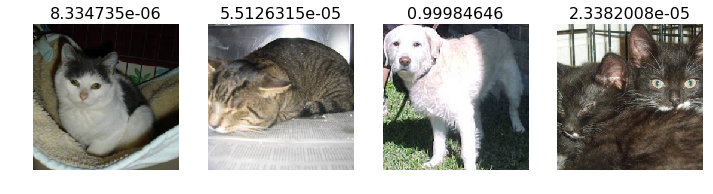

In [50]:
plot_val_with_title(rand_by_correct(True), 'Correctly classified')

* Can plot a few incorrect labels at random:

Incorrectly classified


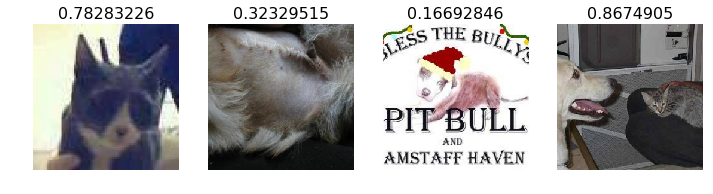

In [53]:
plot_val_with_title(rand_by_correct(False), 'Incorrectly classified')

In [62]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

* Plot the most incorrect cats (what cats are we most wrong about):

Most incorrect cats


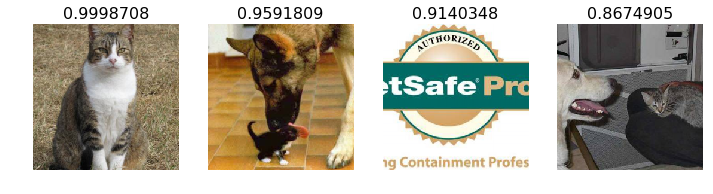

In [63]:
plot_val_with_title(most_by_correct(0, False), 'Most incorrect cats')

* Plot the most incorrect dogs:

Most incorrect dogs


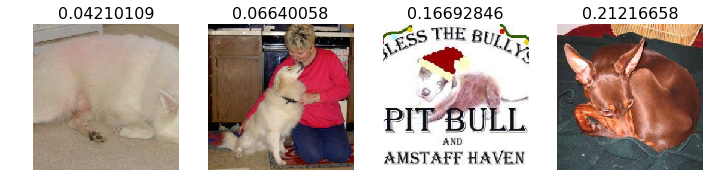

In [64]:
plot_val_with_title(most_by_correct(1, False), 'Most incorrect dogs')

* Plot the most correct cats:

Most correct cats


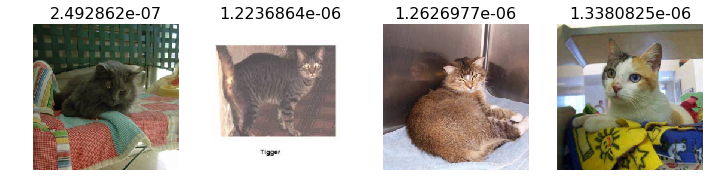

In [65]:
plot_val_with_title(most_by_correct(0, True), 'Most correct cats')

* Plot the most correct dogs:

Most correct dogs


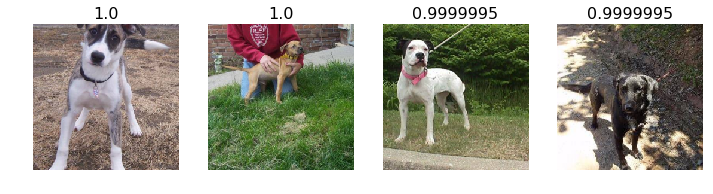

In [67]:
plot_val_with_title(most_by_correct(1, True), 'Most correct dogs')

* Plot the most uncertain dogs:

Most uncertain predictions


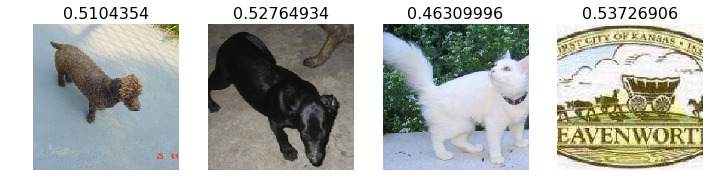

In [68]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, 'Most uncertain predictions')

## 00:27:45 - Why look at your data?

* Always the first thing to do after training model: visualise what it built.
* In this example, we get some insight into our dataset.
  * Maybe need to use data augmentation? Will learn about it later.

## 00:30:55 - More on top-down approach

* You just learn to train a neural network, but you don't know anything about what an NN is.
* Gradually going to need to learn more and more problems, as you do so, you'll need more theory and more understanding of the library.
* Sometimes called "the whole game", inspired by Harvard Professor David Perkins: more like how you'd learn baseball or music.
  * Learn to play baseball, before you learn the physics of how a curve ball works.

## 00:33:50 - Course Structure

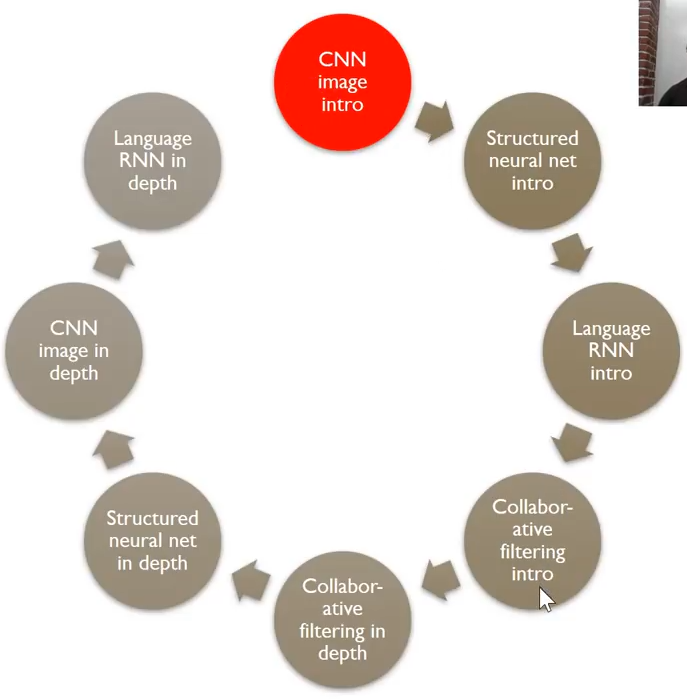

* Start by using NN to look at image data.
* Then structured data.
  * Data that comes from spreadsheets or databases.
* Then language data.
  * Figure out sentiment of movie reviews.
* Then collaborative filtering.
  * Figure out how to recommend stuff to users based on what other users liked.

* By the end of the course, you'll know how to create a world class:
  * Image classifier.
  * Structure data analysis program.
  * Language classifier.
  * Recommendation system.
  
## 00:35:45 - Plan

* Lesson 1:
  * Learn how to build an image classifier in a few lines of code.
* Lesson 2:
  * Learn about different image models.
  * Detect multiple things in satellite images (multi-label classification problem).
* Lesson 3:
  * Structured data.
* Lesson 4:
  * NLP classifiers.
* Lesson 5:
  * Recommendation systems using collaborative filtering.
  * Finding most similar user to another to find movies they might like.
* Lesson 6
  * RNNs.
  * Generative text.
* Lesson 7:
  * Find heap maps in images - "not just if it's a cat but where the cat is".
  * Implementing a ResNet from scratch.

## 00:39:15 - Feedback from previous students
  * "I should have spent the majority of time actually running code from the class."
    * "See what comes in, see what comes out."
  
## 00:40:10 - Traditional ML advice compared to top-down approach
  * Traditional ML advice differs from Jeremy's approach.
    * Example from Hacker News where author who claims the  way to get into ML is to spend years learning maths, C/C++ then start learning ML: https://news.ycombinator.com/item?id=12901536.
    
## 00:42:42 - Image classifier uses

* AlphaGo's recent achievments was made possible by image classification:
  * Train of thousands of in-game Go boards with final win or loser labels.
* Earlier student got a patent for anti-fraud software by looking at pictures of user's mouse paths to predict fraudulent behaviour.

## 00:44:34 - Deep Learning overview

* Deep learning is a form of Machine Learning.
* Machine learning was invented by [Arthur Samuel](https://en.wikipedia.org/wiki/Arthur_Samuel) who build a system to play checkers.
  * Kind of reinforcement learning.
  * Arthur predicted that programs would be written by machines, though it's only happening now.
    * Traditional ML used to be very hard.
* Andy Beck research: worked with pathologists to build features to help predict survival of cells.
  * Features were passed into logistic regression to predict survival.
  * Worked well, but not flexible; required lots of domain expertise.
* What you want out of an algorithm: 
    1. Infinitely flexible function.
    2. All-purpose parameter fitting.
    3. Fast and scalable.
* Deep learning can do that!
  * A "class of algorithms"

## 00:48:45 - Neural Network

* Underlying function that deep learning uses.
* All you need to know: consists of a number of simple linear layers, interspersed with a number of non-layer layer. 
  * Gives you a "universal approximation theorum".
 